#### Installs and imports section

##### Imports

In [24]:
# Scraping libaries
import requests # To send HTTP requests to the website
from bs4 import BeautifulSoup # To parse the HTML content of the page
import pandas as pd # To handle data manipulation and create dataframes

# Sentiment Analysis
from textblob import TextBlob # To perform sentiment analysis on reviews

# Words Frequencies Analysis
from collections import Counter  # To count word frequencies
import re  # For regular expressions, used in text cleaning
import nltk  # To download stopwords and handle text processing
from nltk.corpus import stopwords  # Stopwords list to remove common words
from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer

# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt  # To create visualizations and plots
import seaborn as sns  # For visualizations and enhanced plots
from wordcloud import WordCloud  # To generate a word cloud visualization

##### Installs

In [18]:
# NLTK Downloads (Uncomment to download required resources)
# nltk.download('punkt')  # Tokenizer models for text processing
# nltk.download('averaged_perceptron_tagger')  # Part-of-speech tagger models
# nltk.download('stopwords')  # Download stopwords list for text cleaning
# nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# !pip install --upgrade textblob # Install or upgrade WordCloud for visualizations

In [4]:
# !pip install --upgrade wordcloud # Install or upgrade TextBlob for sentiment analysis

# TASK 1 - Web scraping to gain company insights

This notebook performs web scraping, data cleaning, sentiment analysis, and theme extraction from British Airways customer reviews.

## Step 1: Scraping Customer Reviews

The first step is to scrape customer reviews from the Skytrax website. This is achieved using Python libraries 'BeautifulSoup' and 'requests'. The text of customer reviews is collected and saved for further analysis.

In [10]:
# Initialize lists to store scraped data
review_texts = []

# Scraping reviews from the first few pages
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 1 
page_size = 100

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    
    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    
    # Collect HTML data from this page
    response = requests.get(url)
    
    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    # Find all review content
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        review_texts.append(para.get_text())

    print(f"   ---> {len(review_texts)} total reviews")

# Create a DataFrame from the collected reviews
df_reviews = pd.DataFrame(review_texts, columns=["review_text"])

# Save the DataFrame to a CSV file
df_reviews.to_csv('data/british_airways_reviews.csv', index=False)

# Display the first few rows of the DataFrame
df_reviews.head()


Scraping page 1
   ---> 100 total reviews


,review_text
0,✅ Trip Verified | As someone who flies relentl...
1,✅ Trip Verified | Flew with British Airways ...
2,✅ Trip Verified | Straightforward check in T...
3,Not Verified | I am beyond upset and disgusted...
4,✅ Trip Verified | I purchased round trip dir...


## Step 2: Cleaning and Preprocessing the Data


Once the reviews are scraped, they need to be cleaned by removing unnecessary labels such as "Trip Verified" and "Not Verified" and formatting the text for further analysis.

In [19]:
# Load the dataset
df = pd.read_csv('data/british_airways_reviews.csv')

# Drop unnecessary index column (if present)
df_cleaned = df

# Remove "Trip Verified" and "Not Verified" labels from the reviews
df_cleaned['cleaned_reviews'] = df_cleaned['review_text'].str.replace(r'✅ Trip Verified \|', '', regex=True)
df_cleaned['cleaned_reviews'] = df_cleaned['cleaned_reviews'].str.replace(r'Not Verified \|', '', regex=True)

# Clean up extra spaces and special characters
df_cleaned['cleaned_reviews'] = df_cleaned['cleaned_reviews'].str.strip()

# Display the cleaned data
df_cleaned[['review_text', 'cleaned_reviews']].head()


,review_text,cleaned_reviews
0,✅ Trip Verified | As someone who flies relentl...,As someone who flies relentlessly with British...
1,✅ Trip Verified | Flew with British Airways ...,Flew with British Airways club Europe on Satur...
2,✅ Trip Verified | Straightforward check in T...,Straightforward check in T5. New site for club...
3,Not Verified | I am beyond upset and disgusted...,I am beyond upset and disgusted with the disre...
4,✅ Trip Verified | I purchased round trip dir...,I purchased round trip direct flight business ...


In [20]:
# # Print the first cleaned review in its entirety
# first_cleaned_review = df_cleaned.iloc[0]['cleaned_reviews']
# print("First Cleaned Review:")
# print(first_cleaned_review)

## Step 3: Sentiment Analysis

Using the 'TextBlob' library, sentiment analysis is performed on the cleaned reviews. Each review is classified as positive, negative, or neutral based on the text content.

In [21]:
# Function to classify sentiment based on polarity
def get_sentiment(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment analysis to the cleaned reviews
df_cleaned['Sentiment'] = df_cleaned['cleaned_reviews'].apply(get_sentiment)

# Display the first few rows with sentiment classification
df_cleaned[['cleaned_reviews', 'Sentiment']].head()

,cleaned_reviews,Sentiment
0,As someone who flies relentlessly with British...,Negative
1,Flew with British Airways club Europe on Satur...,Negative
2,Straightforward check in T5. New site for club...,Positive
3,I am beyond upset and disgusted with the disre...,Negative
4,I purchased round trip direct flight business ...,Positive


## Step 3: Word Frequency Analysis
To identify common themes, it’s important to extract frequently mentioned words from both positive and negative reviews.

In [25]:
# Data Cleaning and Sentiment Analysis
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Clean and tokenize review text
def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    words = text.lower().split()  # Tokenize and convert to lowercase
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords and lemmatize
    return words

# Tokenize positive and negative reviews
positive_reviews = df_cleaned[df_cleaned['Sentiment'] == 'Positive']['cleaned_reviews'].apply(clean_and_tokenize)
negative_reviews = df_cleaned[df_cleaned['Sentiment'] == 'Negative']['cleaned_reviews'].apply(clean_and_tokenize)

# Flatten the lists of words for word frequency analysis
positive_words = [word for sublist in positive_reviews for word in sublist]
negative_words = [word for sublist in negative_reviews for word in sublist]

# Get the most common words
positive_word_freq = Counter(positive_words).most_common(10)
negative_word_freq = Counter(negative_words).most_common(10)

# Display the most common words in positive and negative reviews
print("Common words in positive reviews:", positive_word_freq)
print("Common words in negative reviews:", negative_word_freq)

positive_word_freq_total = Counter(positive_words).most_common()
negative_word_freq_total = Counter(negative_words).most_common()

Common words in positive reviews: [('flight', 165), ('ba', 114), ('seat', 51), ('crew', 49), ('service', 45), ('hour', 42), ('time', 41), ('good', 29), ('food', 29), ('one', 29)]
Common words in negative reviews: [('flight', 128), ('ba', 55), ('seat', 41), ('service', 35), ('hour', 35), ('told', 29), ('time', 28), ('luggage', 28), ('british', 27), ('customer', 27)]


In [26]:
# Categorize words into specific themes
def categorize_words(word_freq):
    categories = {
        'Service': ['service', 'crew', 'staff', 'customer'],
        'Flight Experience': ['flight', 'seat', 'time', 'hour', 'plane', 'experience'],
        'Amenities': ['food', 'drink', 'business', 'class'],
        'Other': ['luggage', 'told', 'check', 'delay', 'customer', 'problem']
    }
    
    categorized = {'Service': 0, 'Flight Experience': 0, 'Amenities': 0, 'Other': 0}
    
    # Sum the frequency of words for each category
    for word, freq in word_freq:
        for category, words in categories.items():
            if word in words:
                categorized[category] += freq
    
    return categorized

# Categorize positive and negative word frequencies
positive_categorized_total = categorize_words(positive_word_freq_total)
negative_categorized_total = categorize_words(negative_word_freq_total)

# Display the categorized results for better context
print("\nCategorized Feedback (Positive Reviews):")
for category, freq in positive_categorized_total.items():
    print(f"{category}: {freq} mentions")

print("\nCategorized Feedback (Negative Reviews):")
for category, freq in negative_categorized_total.items():
    print(f"{category}: {freq} mentions")


Categorized Feedback (Positive Reviews):
Service: 127 mentions
Flight Experience: 339 mentions
Amenities: 103 mentions
Other: 77 mentions

Categorized Feedback (Negative Reviews):
Service: 100 mentions
Flight Experience: 278 mentions
Amenities: 63 mentions
Other: 124 mentions


## Step 5: Exploratory Data Analysis (EDA)

Visualizations of the sentiment distribution are created, and a word cloud is generated to highlight common themes in the reviews.

Total number of reviews: 100

Count of Positive, Negative, and Neutral reviews:
Sentiment
Positive    51
Negative    48
Neutral      1
Name: count, dtype: int64


Percentage of Positive, Negative, and Neutral reviews:
Sentiment
Positive    51.0
Negative    48.0
Neutral      1.0
Name: proportion, dtype: float64


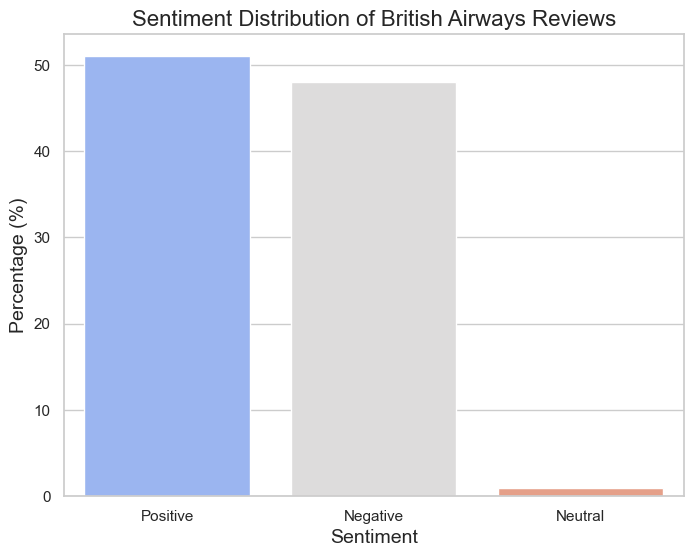

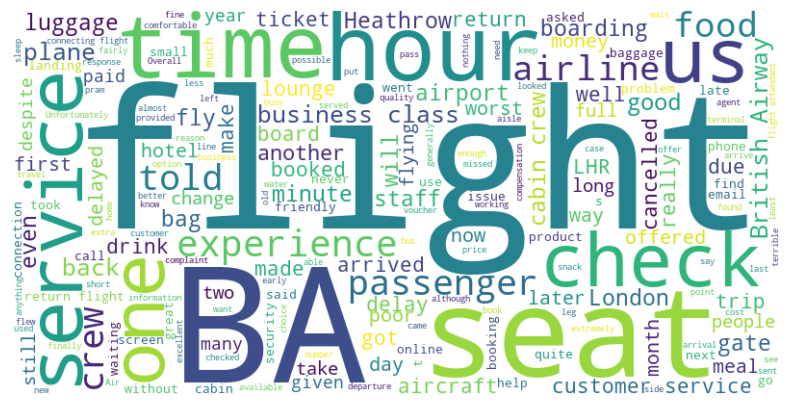

In [9]:
# Count the total number of reviews
total_reviews = len(df_cleaned)
print(f"Total number of reviews: {total_reviews}\n")
# Count the number of positive, negative, and neutral reviews
sentiment_counts = df_cleaned['Sentiment'].value_counts()
print("Count of Positive, Negative, and Neutral reviews:")
print(sentiment_counts)
print(f"\n")

# Calculate the sentiment distribution
sentiment_distribution = df_cleaned['Sentiment'].value_counts(normalize=True) * 100
print("Percentage of Positive, Negative, and Neutral reviews:")
print(sentiment_distribution)

# Set a visual style
sns.set(style="whitegrid")
# Create the sentiment distribution plot
plt.figure(figsize=(8, 6))
# Assign the 'Sentiment' variable to 'hue' and set 'legend=False'
sns.barplot(x=sentiment_distribution.index, 
            y=sentiment_distribution.values, 
            hue=sentiment_distribution.index, 
            palette="coolwarm", 
            legend=False)
# Add titles and labels
plt.title('Sentiment Distribution of British Airways Reviews', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
# Save the plot as an image (PNG format)
plt.savefig('sentiment_distribution_plot.png', format='png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


# Generate a word cloud for the most common words in the reviews
all_reviews = ' '.join(df_cleaned['cleaned_reviews'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# Save the plot as an image (PNG format)
plt.savefig('sentiment.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


## Key Insights and Findings
### Overview:
**Sentiment Distribution**: The reviews have been classified into positive, negative, and neutral sentiment categories. The results indicate that a significant portion of the reviews are negative, pointing to areas of concern for British Airways.

**Common Themes**: A word cloud highlights the most frequent words in the reviews, providing insights into the main topics of concern or praise from customers.